In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

2019                                                              \
       count      mean       std       min       25%       50%       75%   
type                                                                       
PP    2562.0  0.099677  0.036166 -0.205667  0.087568  0.104509  0.122703   
TT    7438.0  0.039586  0.048360 -0.165674  0.001760  0.021739  0.079333   

                  2020            ...                        2021            \
           max   count      mean  ...       75%       max   count      mean   
type                              ...                                         
PP    0.223079  2562.0  0.085082  ...  0.108783  0.173772  2562.0  0.125089   
TT    0.242291  7438.0  0.023967  ...  0.043605  0.150519  7438.0  0.046996   

                                                                  
           std       min       25%       50%       75%       max  
type                                                              
PP    0.047384 -0.081836  0.095371  0.134625  0.160870  0.234467  
TT    0.064713 -0.311729 -0.004538  0.014910  0.100643  0.269995  

[2 rows x 24 columns]

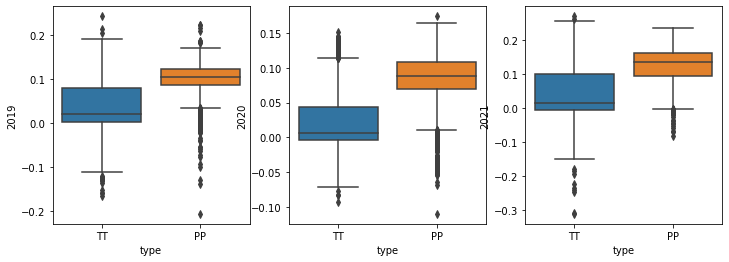

In [14]:
No_till_raster_data =  rasterio.open('raster_data/minNDTI/RGBs/Krasnoselskoe_RGB.tif').read().reshape(3,-1).T
traditional_raster_data = rasterio.open('raster_data/minNDTI/RGBs/Praskoveya_RGB.tif').read().reshape(3,-1).T

No_till_raster_data[No_till_raster_data == -10] = np.nan
No_till_raster_data[No_till_raster_data == 0] = np.nan
No_till_raster_data = No_till_raster_data[~np.isnan(No_till_raster_data).any(axis=1)]
No_till_df = pd.DataFrame(No_till_raster_data, columns=['2019','2020','2021'])
No_till_df['type'] = 'PP'



traditional_raster_data[traditional_raster_data == -10] = np.nan
traditional_raster_data[traditional_raster_data == 0] = np.nan
traditional_raster_data = traditional_raster_data[~np.isnan(traditional_raster_data).any(axis=1)]
traditional_df = pd.DataFrame(traditional_raster_data, columns=['2019','2020','2021'])
traditional_df['type'] = 'TT'

general_df = No_till_df.append(traditional_df)

sample = general_df.sample(n = 10000, random_state= 14)

fig, axes = plt.subplots(1,3, figsize=(12,4)) 

sns.boxplot(data = sample , x = 'type', y = '2019', ax = axes[0])
sns.boxplot(data = sample , x = 'type', y = '2020', ax = axes[1])
sns.boxplot(data = sample , x = 'type', y = '2021', ax = axes[2])



sample.groupby(['type']).describe()


как мы видим выбросов довольно много это понятно данные очень разрозненные и изначально у нас были только геометрии полей и информация что есть очень качественный прямой посев и классическая традиционка поэтому есть мысль что нужно почистить данные от лишнего обрезав датасет по 1.5 IQR


In [15]:
def cut_by_15IQR(data):
    first = np.array(data.describe().iloc[4]) # первый квартиль
    third  = np.array(data.describe().iloc[6]) # третий квартиль

    IQL1_5 = 1.5 *(third - first) # 1.5 межквартильного размаха
    top = third + IQL1_5
    bottom = first - IQL1_5
    df = data.copy()
    for i in range(IQL1_5.shape[0]):
        df = df[( df.iloc[:,i] <= top[i]) & ( df.iloc[:,i] >= bottom[i]) ]
    return(df)

2019                                                              \
       count      mean       std       min       25%       50%       75%   
type                                                                       
PP    5000.0  0.105977  0.024225  0.031716  0.089494  0.106308  0.123379   
TT    5000.0  0.039981  0.047298 -0.105187  0.003376  0.022798  0.078461   

                  2020            ...                        2021            \
           max   count      mean  ...       75%       max   count      mean   
type                              ...                                         
PP    0.175027  5000.0  0.093586  ...  0.112488  0.168858  5000.0  0.128621   
TT    0.191772  5000.0  0.020537  ...  0.041038  0.113302  5000.0  0.049235   

                                                                  
           std       min       25%       50%       75%       max  
type                                                              
PP    0.044117 -0.002551  0.098790  0.137931  0.162121  0.234314  
TT    0.064491 -0.156611 -0.004522  0.017855  0.102492  0.255928  

[2 rows x 24 columns]

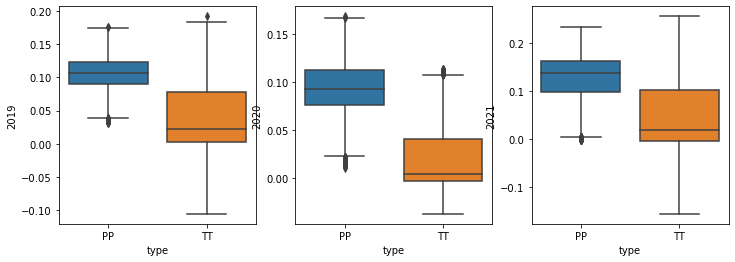

In [16]:

No_till_df_cuted = cut_by_15IQR(No_till_df).sample(n = 5000, random_state= 14)
traditional_df_cuted = cut_by_15IQR(traditional_df).sample(n = 5000, random_state= 14) #сразу по 5к отобрать


general_df = No_till_df_cuted.append(traditional_df_cuted)


sample = general_df

fig, axes = plt.subplots(1,3, figsize=(12,4)) 

sns.boxplot(data = sample , x = 'type', y = '2019', ax = axes[0])
sns.boxplot(data = sample , x = 'type', y = '2020', ax = axes[1])
sns.boxplot(data = sample , x = 'type', y = '2021', ax = axes[2])



sample.groupby(['type']).describe()




видно как данные группируются на прямой посев и традиционную обработку 


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

X = sample[['2019','2020','2021']].values
y = sample['type'].values.reshape(-1,1)

y[y == 'TT'] = 0
y[y == 'PP'] = 1
y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(X , y,test_size = 0.2, random_state=13)

In [18]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1017
           1       0.94      0.95      0.94       983

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



0.9498749999999999

In [19]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)
predictions = neigh.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1017
           1       1.00      0.99      1.00       983

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



0.9498749999999999

In [20]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1017
           1       1.00      0.99      0.99       983

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



0.9903749999999999

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1017
           1       1.00      1.00      1.00       983

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



0.9938750000000001

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1017
           1       0.99      0.99      0.99       983

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



0.992125

как и следовало ожидать лучший вариант на дефолтных настройках это градиентный бустинг, пресижн и рекол для класса прямой посев самая высокая 

In [23]:
Gboosting = GradientBoostingClassifier(random_state=0)
Gboosting.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

In [24]:
Krasnoselskoe = rasterio.open('raster_data/minNDTI/RGBs/Krasnoselskoe_RGB.tif')
Archangelskoe = rasterio.open('raster_data/minNDTI/RGBs/Archangelskoe_RGB.tif')
Praskoveya = rasterio.open('raster_data/minNDTI/RGBs/Praskoveya_RGB.tif')
Aleksandr = rasterio.open('raster_data/minNDTI/RGBs/Aleksandr_RGB.tif')
Volgograd = rasterio.open('raster_data/minNDTI/RGBs/RGB_volgograd.tif')

def mapping(raster, vector, name):
    meta_data = raster.meta
    CRS = raster.crs
    meta_data['count'] = 1
    meta_data['dtype'] = 'float64'

    dir = f'output/classified_rasters/{name}_classified.tif'

    raster_shape = raster.shape
    data = raster.read().reshape(3,-1).T
    proba_data = Gboosting.predict_proba(data)[:,1]
    proba_data = proba_data.reshape(raster_shape)
    new_dataset = rasterio.open(dir, 'w', **meta_data)
    new_dataset.write(proba_data, 1)
    new_dataset.close()

    vector_reproj = vector.to_crs(CRS)

    classified_data = rasterio.open(dir, 'r')


    masked_raster, affine__ = mask(classified_data ,vector_reproj.geometry, invert= False)
    new_dataset = rasterio.open(dir, 'w', **meta_data)
    new_dataset.write(masked_raster)
    new_dataset.close()

farmers_list = [Aleksandr,Archangelskoe, Krasnoselskoe, Praskoveya ]
geometries = gpd.read_file('vector_data/fields.geojson')


geometries = geometries.dissolve(by = "farmer_land_name").reset_index()
farmer_name_array = geometries.farmer_land_name.unique()



In [25]:
Volgograd = rasterio.open('raster_data/minNDTI/RGBs/RGB_volgograd.tif')
Volgograd_geometry = gpd.read_file('vector_data/project_bounds.geojson')

In [30]:
mapping(Volgograd, Volgograd_geometry, "Волгоград.tif" )

In [133]:
for i in range(len(farmer_name_array)):
    geometry = geometries[geometries.farmer_land_name == farmer_name_array[i]]
    raster = farmers_list[i]
    raster_name = farmer_name_array[i]
    mapping(raster, geometry, raster_name )
